In [22]:
pip install -U pandas numpy tqdm radon sacrebleu torch transformers


In [23]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
from transformers import AutoTokenizer, AutoModel
import sacrebleu

from radon.metrics import mi_visit, h_visit
from radon.complexity import cc_visit

In [24]:
# ------------------------------------------------------------
# (a) Load Dataset (from Lab 2)
# ------------------------------------------------------------

CSV_PATH = "bugfix_diffs_with_llm_and_rectifier.csv"  # <-- Adjust this path

# Map column names from Lab 2 dataset to canonical ones
COLS = {
    "hash": "Hash",
    "message": "Message",
    "filename": "Filename",
    "code_before": "Source Code (before)",
    "code_after": "Source Code (current)",
    "diff": "Diff",
    "fix_type": "LLM Inference (fix type)",
    "rect_msg": "Rectified Message",
}

# Load dataset
df = pd.read_csv(CSV_PATH)

# Sanity check: ensure required columns exist
required = [COLS["hash"], COLS["message"], COLS["filename"],
            COLS["code_before"], COLS["code_after"],
            COLS["diff"], COLS["fix_type"], COLS["rect_msg"]]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Dataset is missing required columns: {missing}")


In [25]:
# ------------------------------------------------------------
# (b) Baseline Descriptive Statistics
# ------------------------------------------------------------

total_commits = df[COLS["hash"]].nunique()
total_files   = len(df)

# Avg. modified files per commit
files_per_commit = df.groupby(COLS["hash"])[COLS["filename"]].nunique()
avg_files_per_commit = files_per_commit.mean()

# Distribution of fix types (from LLM inference)
fix_type_dist = df[COLS["fix_type"]].value_counts(dropna=False)

# Most frequently modified filenames and extensions
df["_ext"] = df[COLS["filename"]].str.rsplit(".", n=1).str[-1].str.lower()
top_files = df[COLS["filename"]].value_counts().head(10)
top_exts  = df["_ext"].value_counts().head(10)

print("Total commits:", total_commits)
print("Total files:", total_files)
print("Average modified files per commit:", round(avg_files_per_commit, 3))
print("\nFix type distribution:\n", fix_type_dist)
print("\nTop filenames:\n", top_files)
print("\nTop extensions:\n", top_exts)


Total commits: 295
Total files: 881
Average modified files per commit: 2.861

Fix type distribution:
 LLM Inference (fix type)
Create __init__.py                                20
Remove unused import                              15
Fix lint                                          14
Add example                                       13
Add missing import                                11
                                                  ..
Add examples for stockprice                        1
Fix docx type in docxreader                        1
Fix error when reading a file from a directory     1
Fix ollama response stream                         1
Fix monitoring flag                                1
Name: count, Length: 681, dtype: int64

Top filenames:
 Filename
phi/agent/agent.py                          20
pyproject.toml                              19
phi/playground/playground.py                16
phi/tools/fal_tools.py                      15
cookbook/playground/multimodal_agent.

In [26]:
import gc
gc.collect()     # Clean Python objects
torch.cuda.empty_cache()  # Free GPU memory


In [62]:
# ------------------------------------------------------------
# (c) Structural Metrics with Radon - Fixed Version
# ------------------------------------------------------------
def is_python_file(name: str) -> bool:
    """Check if a file is a Python source file."""
    return isinstance(name, str) and name.strip().lower().endswith(".py")

def safe_mi(code: str):
    """Compute Maintainability Index (MI)."""
    try:
        return float(mi_visit(code, multi=True))
    except Exception:
        return np.nan

def safe_cc_sum(code: str):
    """Compute total Cyclomatic Complexity (CC)."""
    try:
        blocks = cc_visit(code)
        return float(sum(getattr(b, "complexity", 0) for b in blocks))
    except Exception:
        return np.nan

def safe_loc(code: str):
    """Compute Lines of Code (LOC). Try radon first, else fallback to raw line count."""
    try:
        metrics = h_visit(code)
        if isinstance(metrics, dict) and metrics:
            first_key = next(iter(metrics))
            return int(metrics[first_key].loc)
        elif hasattr(metrics, "loc"):
            return int(metrics.loc)
    except Exception:
        pass

    # Fallback: count non-empty lines manually
    try:
        return sum(1 for line in code.splitlines() if line.strip())
    except Exception:
        return np.nan



def radon_metrics_row(row):
    """Compute MI, CC, LOC for before and after versions of a file."""
    fname = row[COLS["filename"]]
    before = row[COLS["code_before"]] if isinstance(row[COLS["code_before"]], str) else ""
    after  = row[COLS["code_after"]]  if isinstance(row[COLS["code_after"]], str)  else ""

    result = {
        "MI_Before": np.nan, "MI_After": np.nan,
        "CC_Before": np.nan, "CC_After": np.nan,
        "LOC_Before": np.nan, "LOC_After": np.nan
    }

    if is_python_file(fname):
        result["MI_Before"] = safe_mi(before)
        result["MI_After"]  = safe_mi(after)
        result["CC_Before"] = safe_cc_sum(before)
        result["CC_After"]  = safe_cc_sum(after)
        result["LOC_Before"] = safe_loc(before)
        result["LOC_After"]  = safe_loc(after)

    return pd.Series(result)

# --- Apply Radon metrics ---
struct = df.apply(radon_metrics_row, axis=1)

# Make sure struct has the right columns
struct = struct.astype({
    "MI_Before": "float64", "MI_After": "float64",
    "CC_Before": "float64", "CC_After": "float64",
    "LOC_Before": "float64", "LOC_After": "float64"
})

# Drop duplicates if already exist
df = df.drop(columns=[c for c in struct.columns if c in df.columns], errors="ignore")

# Merge clean
df = pd.concat([df, struct], axis=1)

# Now compute deltas
df["MI_Change"]  = df["MI_After"]  - df["MI_Before"]
df["CC_Change"]  = df["CC_After"]  - df["CC_Before"]
df["LOC_Change"] = df["LOC_After"] - df["LOC_Before"]


In [63]:
# ------------------------------------------------------------
# (d) Change Magnitude Metrics
# ------------------------------------------------------------

import sacrebleu

def bleu_token_similarity(ref: str, hyp: str) -> float:
    """
    Compute BLEU similarity using sacreBLEU.
    Returns normalized score in [0,1].
    """
    ref = ref if isinstance(ref, str) else ""
    hyp = hyp if isinstance(hyp, str) else ""
    if not ref.strip() and not hyp.strip():
        return 1.0  # identical empties
    if not ref.strip() or not hyp.strip():
        return 0.0  # one side empty
    score = sacrebleu.sentence_bleu(hyp, [ref])
    return float(score.score / 100.0)


# Load CodeBERT model & tokenizer
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
tok = AutoTokenizer.from_pretrained("microsoft/codebert-base")
model = AutoModel.from_pretrained("microsoft/codebert-base").to(DEVICE)
model.eval()

tqdm.pandas()

df["Token_Similarity"] = df.progress_apply(
    lambda r: bleu_token_similarity(r[COLS["code_before"]], r[COLS["code_after"]]),
    axis=1
)

def codebert_embed(text: str) -> torch.Tensor:
    """Get CodeBERT embedding (mean-pooled)."""
    if not isinstance(text, str) or not text.strip():
        return torch.zeros(768)
    with torch.no_grad():
        inputs = tok(text, truncation=True, max_length=512, padding="max_length", return_tensors="pt").to(DEVICE)
        out = model(**inputs).last_hidden_state  # shape: [1, 512, 768]
        return out.mean(dim=1).squeeze(0).detach().cpu()

def cosine(a: torch.Tensor, b: torch.Tensor) -> float:
    """Cosine similarity between two embeddings."""
    if a.norm() == 0 or b.norm() == 0:
        return 0.0
    return float(torch.nn.functional.cosine_similarity(a.unsqueeze(0), b.unsqueeze(0)).item())

def bleu_token_similarity(ref: str, hyp: str) -> float:
    """
    Compute BLEU similarity using sacreBLEU.
    Returns normalized score in [0,1].
    """
    ref = ref if isinstance(ref, str) else ""
    hyp = hyp if isinstance(hyp, str) else ""
    if not ref.strip() and not hyp.strip():
        return 1.0  # identical empties
    if not ref.strip() or not hyp.strip():
        return 0.0  # one side empty
    score = sacrebleu.sentence_bleu(hyp, [ref])
    return float(score.score / 100.0)

# Precompute embeddings for semantic similarity
emb_before, emb_after = [], []
for code_b, code_a in tqdm(zip(df[COLS["code_before"]], df[COLS["code_after"]]),
                           total=len(df), desc="Embedding with CodeBERT"):
    emb_before.append(codebert_embed(code_b))
    emb_after.append(codebert_embed(code_a))

# Semantic similarity (cosine between embeddings)
df["Semantic_Similarity"] = [cosine(a, b) for a, b in zip(emb_before, emb_after)]

# Token similarity (BLEU overlap)
df["Token_Similarity"] = df.progress_apply(
    lambda r: bleu_token_similarity(r[COLS["code_before"]], r[COLS["code_after"]]),
    axis=1
)

100%|██████████| 881/881 [00:11<00:00, 75.94it/s] 


In [64]:
# ------------------------------------------------------------
# (e) Classification & Agreement
# ------------------------------------------------------------

SEM_MINOR_TH = 0.80  # Semantic similarity threshold
TOK_MINOR_TH = 0.75  # Token similarity threshold

def classify_sem(v: float) -> str:
    """Classify commit based on semantic similarity."""
    return "Minor" if v >= SEM_MINOR_TH else "Major"

def classify_tok(v: float) -> str:
    """Classify commit based on token similarity."""
    return "Minor" if v >= TOK_MINOR_TH else "Major"

df["Semantic_class"] = df["Semantic_Similarity"].apply(classify_sem)
df["Token_class"]    = df["Token_Similarity"].apply(classify_tok)
df["Classes_Agree"]  = (df["Semantic_class"] == df["Token_class"]).map({True: "YES", False: "NO"})


In [65]:
# ------------------------------------------------------------
# (f) Final Export
# ------------------------------------------------------------

final_cols = [
    COLS["hash"], COLS["message"], COLS["filename"],
    COLS["code_before"], COLS["code_after"], COLS["diff"],
    COLS["fix_type"], COLS["rect_msg"],
    "MI_Before", "MI_After", "MI_Change",
    "CC_Before", "CC_After", "CC_Change",
    "LOC_Before", "LOC_After", "LOC_Change",
    "Semantic_Similarity", "Token_Similarity",
    "Semantic_class", "Token_class", "Classes_Agree"
]

final_df = df[final_cols].copy()

OUT_CSV = "lab3_multimetric_results.csv"
final_df.to_csv(OUT_CSV, index=False)
print(f"\nWrote results to: {OUT_CSV}")


Wrote results to: lab3_multimetric_results.csv


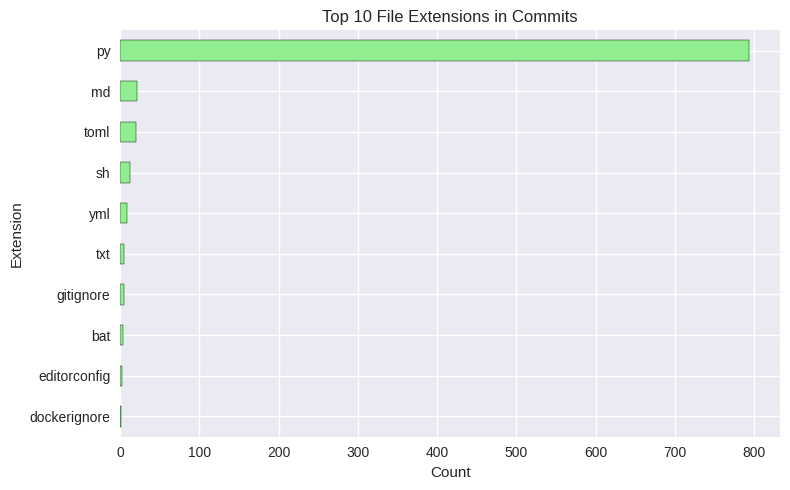

In [66]:
import matplotlib.pyplot as plt

# Use consistent style
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (8, 5)

# ------------------------------------------------------------
# Top File Extensions (horizontal bar chart)
# ------------------------------------------------------------
top_exts = final_df["Filename"].str.rsplit(".", n=1).str[-1].str.lower().value_counts().head(10)

top_exts.plot(kind="barh", color="lightgreen", edgecolor="black")
plt.title("Top 10 File Extensions in Commits")
plt.xlabel("Count")
plt.ylabel("Extension")
plt.gca().invert_yaxis()  # largest first
plt.tight_layout()
plt.show()



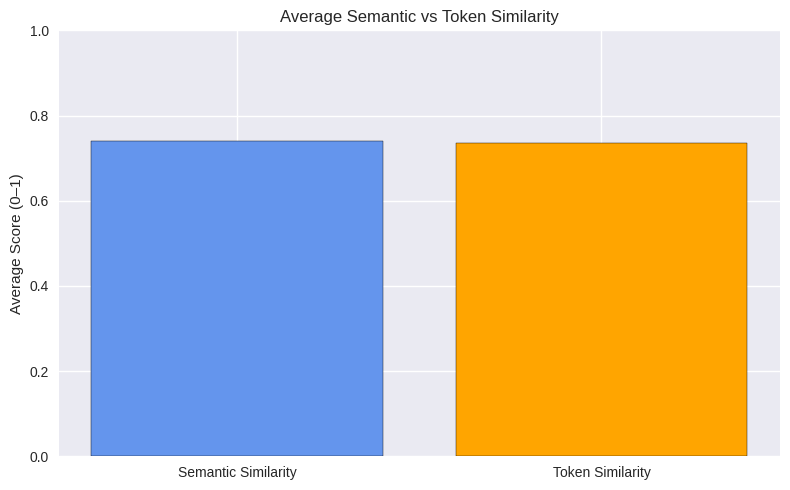

In [67]:
# ------------------------------------------------------------
# Distribution of Semantic vs Token Similarity (bar chart of averages)
# ------------------------------------------------------------
avg_sem = final_df["Semantic_Similarity"].mean()
avg_tok = final_df["Token_Similarity"].mean()

plt.bar(["Semantic Similarity", "Token Similarity"], [avg_sem, avg_tok],
        color=["cornflowerblue", "orange"], edgecolor="black")
plt.ylim(0, 1)
plt.title("Average Semantic vs Token Similarity")
plt.ylabel("Average Score (0–1)")
plt.tight_layout()
plt.show()



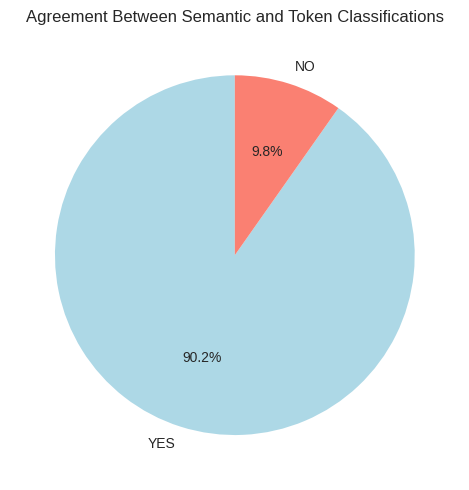

In [68]:
# ------------------------------------------------------------
# Agreement vs Disagreement (pie chart)
# ------------------------------------------------------------
agree_counts = final_df["Classes_Agree"].value_counts()

agree_counts.plot(kind="pie", autopct="%1.1f%%",
                  colors=["lightblue", "salmon"], startangle=90)
plt.ylabel("")
plt.title("Agreement Between Semantic and Token Classifications")
plt.tight_layout()
plt.show()


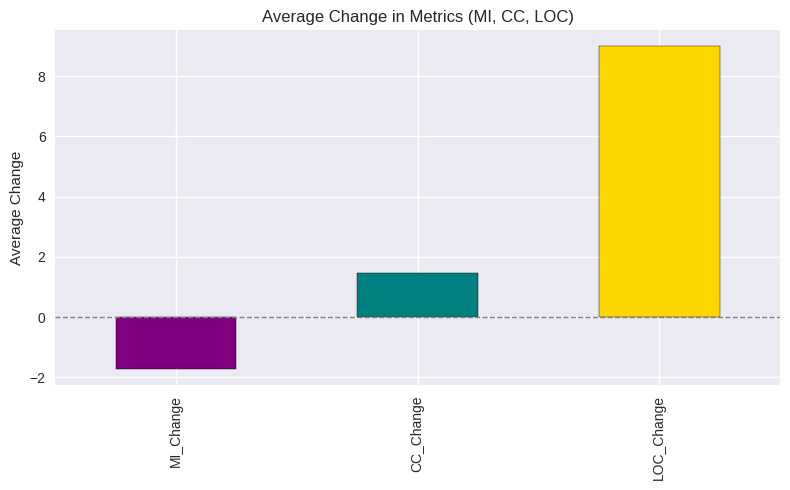

In [69]:

# ------------------------------------------------------------
# MI/CC/LOC Changes (bar chart of averages)
# ------------------------------------------------------------
avg_changes = final_df[["MI_Change", "CC_Change", "LOC_Change"]].mean()

avg_changes.plot(kind="bar", color=["purple", "teal", "gold"], edgecolor="black")
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.title("Average Change in Metrics (MI, CC, LOC)")
plt.ylabel("Average Change")
plt.tight_layout()
plt.show()
